## Importing Packages

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

## Topography Setup

In [54]:
# The initial topography setup follows the following:
# y = A*cos[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c (midline)
function initial_surface_depth(x::Float64)
    w = 2.8e6
    A = 7.0e3
    k = (2*pi)/w
    b = 1.4e6
    c = 1.7e4
    return (A) * (cos(k*(x-b))) + (c)
end

function initial_medium_mantle_depth(x::Float64)
     return 1.07e5
end

initial_medium_mantle_depth (generic function with 1 method)

## Material Setup

In [65]:
struct Materials
    # 1 - mantle
    # 2 - medium 
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([3e-5,2e-5,0.0],[3300.0,3300.0,1.0],[2e-8,3e-8,0.0],[1000.0,1000.0,3.3e6],[3.0,2.0,300.0],[1e21,1e23,1e18])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hmed = initial_medium_mantle_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hmed
            # mantle
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 1500.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # medium
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 1800.0
            markers.scalars[eta,i] = materials.eta[2]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 273.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

initial_conditions! (generic function with 1 method)

## Model Setup

In [63]:
function run(nstep::Int64)
    nx = 208
    ny = 140
    W = 2.8e6
    H = 7.17e5
    gx = 0.0
    gy = 10.0

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,273.0,1500.0]
    
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)
    
    air_medium_interface = zeros(Float64,grid.nx+1)
    mantle_medium_interface = zeros(Float64,grid.nx+1)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 1e10

      local rho_c
      local rho_vx
      local rho_vy
      local alpha
      local Hr
      local Cp_c
      local eta_s
      local eta_n
      local vxc
      local vyc
      local T
      local dt
      local dTmax
      local dTemp
      local Tnew
      local Tlast

    output_dir = "test"
    for itime in 1:nstep
        # 1. Transfer properties markers -> nodes
        update_marker_prop!(markers,materials)
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
    
        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer=1
        for titer=1:2
            # assemble and solve the energy equation
#             println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1])) 
#             println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
        
        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        function get_interface(grid::CartesianGrid,mat,contour_value)
            interface_position = zeros(Float64,grid.nx+1);
            for j in 1:grid.nx+1
                i = 1
                while i <= grid.ny
                    if mat[i,j] == contour_value
                        interface_position[j] = grid.yc[i]
                        break
                elseif mat[i+1,j] < contour_value
                        # interface is located within this cell.
                        interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                        break
                    end
                    i = i+1
                end
            end
            return interface_position
        end
        air_medium_interface = get_interface(grid,mat,2.5)
        mantle_medium_interface = get_interface(grid,mat,1.5)

#         if time == 0.0 || time - last_plot >= plot_interval
#             last_plot = time 
#             name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#             println("Writing visualization fle ",name)
#             vn = velocity_to_basic_nodes(grid,vxc,vyc)

#         visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
#             name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#             visualization(markers,time/seconds_in_year;filename=name)
#             iout += 1
#         end
        
#         println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time,air_medium_interface,mantle_medium_interface
end
@time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time,air_medium_interface,mantle_medium_interface = run(1);


Creating Markers...
  0.064101 seconds (19 allocations: 97.205 MiB, 55.64% gc time)
Initial condition...
  0.163358 seconds (3.11 M allocations: 49.772 MiB)
Finished Step 1 time=0.007938358741048895 Myr
  2.876300 seconds (6.24 M allocations: 1.083 GiB, 3.82% gc time, 1.03% compilation time)


## Plots

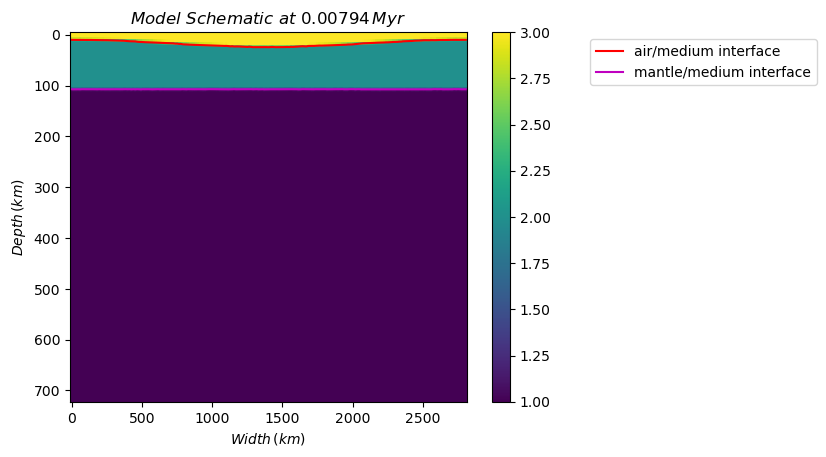

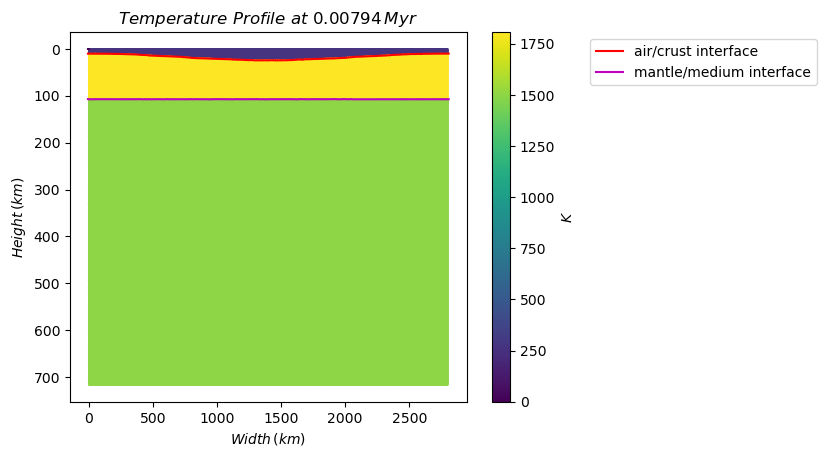

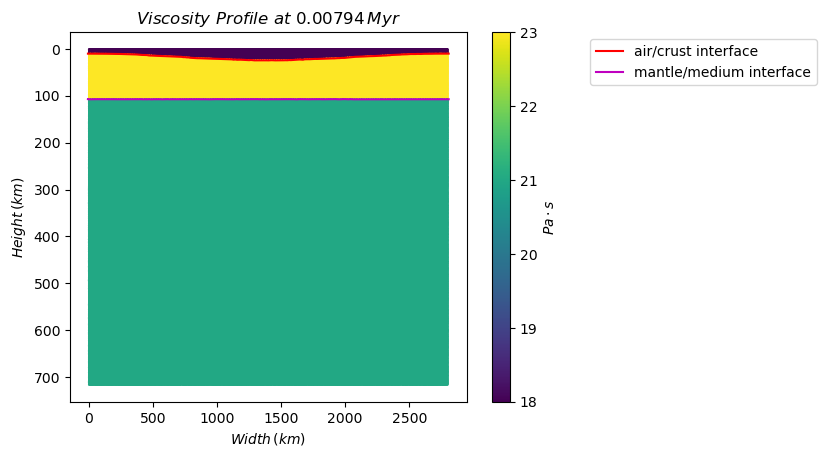

In [64]:
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
x_time = @sprintf("%.3g",time/3.15e7/1e6)

# Model Schematic
# figure(figsize=(12,2))
figure()
pcolor(grid.xc/1000,grid.yc/1000,mat)
colorbar()
plot(grid.xc/1000,air_medium_interface/1000,"r",label="air/medium interface")
plot(grid.xc/1000,mantle_medium_interface/1000,"m",label="mantle/medium interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_ylabel(L"Depth\,(km)")
gca().set_xlabel(L"Width\,(km)") 
# gca().set_aspect("equal")
# legend(loc="upper right",bbox_to_anchor=[1.6,1.0])
legend(loc="upper right",bbox_to_anchor=[1.9,1.0])
show()

# Temperature Profile 
# figure(figsize=(12,3))
figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc/1000,air_medium_interface/1000,"r",label="air/crust interface")
plot(grid.xc/1000,mantle_medium_interface/1000,"m",label="mantle/medium interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
# gca().set_aspect("equal")
# legend(loc="upper right",bbox_to_anchor=[1.5,1.0])
legend(loc="upper right",bbox_to_anchor=[1.9,1.0])
show()

# Viscosity Profile 
# figure(figsize=(12,3))
figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc/1000,air_medium_interface/1000,"r",label="air/crust interface")
plot(grid.xc/1000,mantle_medium_interface/1000,"m",label="mantle/medium interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
# gca().set_aspect("equal")
# legend(loc="upper right",bbox_to_anchor=[1.5,1.0])
legend(loc="upper right",bbox_to_anchor=[1.9,1.0])
show()

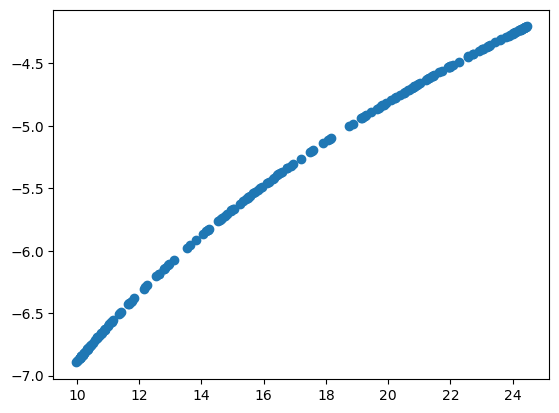

PyObject <matplotlib.collections.PathCollection object at 0x11a3c43a0>

In [99]:
C = ((3/16*pi^3) * ((2.8e6)^3/(air_medium_interface).^3) * (1e17/1e21)) / 1000 
b = log.(C)
scatter(air_medium_interface/1000,b)